# **Generative Models - Part 1: GAN on Frey Dataset**

In [18]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
mpl.rc('image', cmap='gray')
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import get_file
from scipy.io import loadmat
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.utils import get_file
from tqdm.auto import tqdm, trange

## 1. Data Loading and Preprocessing

In [2]:
# Function to load and preprocess Frey dataset
# Adapted from frey_diffusion_example.py
def get_frey_data():
    """Loads and preprocesses the Frey dataset.

    Returns:
        numpy.ndarray: Frey face images, normalized to [-1, 1]
                       with shape (N, 28, 20, 1).
    """
    try:
        path = get_file('frey_rawface.mat',
                        'https://www.dropbox.com/scl/fi/m70sh4ef39pvy01czc63r/frey_rawface.mat?rlkey=5v6meiap55z68ada2roxwxuql&dl=1',
                        cache_subdir='datasets') # Added cache_subdir for better organization
        data = np.transpose(loadmat(path)['ff'])  # Shape (1965, 560)
        # Reshape to (num_images, height, width, channels)
        x_train = np.reshape(data, (-1, 28, 20, 1))
        x_train = x_train.astype('float32')
        x_train /= 255.0  # Normalize to [0, 1]
        x_train = (x_train * 2.0) - 1.0  # Normalize to [-1, 1]
        return x_train
    except Exception as e:
        print(f"Error loading Frey dataset: {e}")
        print("Please ensure you have an internet connection and scipy is installed.")
        print("Alternatively, download 'frey_rawface.mat' manually and place it in '~/.keras/datasets/'.")
        return None

Loaded Frey dataset: (1965, 28, 20, 1)
Example images from Frey dataset:


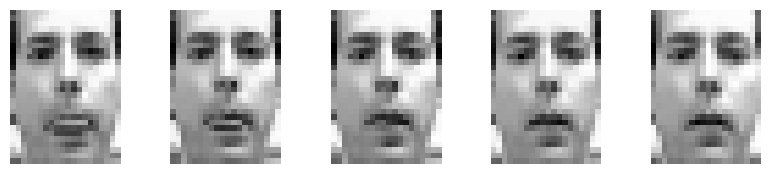

In [3]:
# Load the data
x_train = get_frey_data()

IMG_H, IMG_W, IMG_C = x_train.shape[1:] # Should be 28, 20, 1
print(f"Loaded Frey dataset: {x_train.shape}")

# Display a few example images
print("Example images from Frey dataset:")
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    # De-normalize for display: from [-1, 1] to [0, 1]
    img_display = (x_train[i] + 1.0) / 2.0
    plt.imshow(np.squeeze(img_display))
    plt.axis('off')
plt.show()

## 1.1: Build the model

### Generator Network
The generator network takes a latent vector and outputs a 28x20x1 image.
- Input: latent vector
- Dense layer: 7\*5\*128 outputs, LeakyReLU(alpha=0.1)
- Reshape: (7,5,128)
- Conv2DTranspose 1: 256 filters, stride 2, padding 'same', LeakyReLU(alpha=0.1) -> (14,10,256)
- Conv2DTranspose 2: 1 filter (output channel), stride 2, padding 'same', no activation (linear) -> (28,20,1)

In [4]:
def build_generator(latent_dim):
    inputs = Input((latent_dim,), name='generator_input')

    # Dense layer: 7*5*128 outputs
    x = Dense(7*5*128, activation=None)(inputs)
    x = LeakyReLU(alpha=0.1)(x)

    # Reshape to (7,5,128)
    x = Reshape((7,5,128))(x)

    # Conv2DTranspose 1: stride 2, 256 filters -> (14,10,256)
    x = Conv2DTranspose(256, kernel_size=3, strides=2, padding='same')(x) # Default kernel size 3 is common
    x = LeakyReLU(alpha=0.1)(x)

    # Conv2DTranspose 2: stride 2, 1 output channel -> (28,20,1)
    # Output layer, typically tanh for [-1,1] data, or linear as per MNIST example
    output = Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation=None)(x)

    return Model(inputs=inputs, outputs=output, name='generator')

### Discriminator Network
The discriminator network takes a 28x20x1 image and outputs a probability.
- Input: 28x20x1 image
- Conv2D 1: 256 filters, stride 2, padding 'same', ReLU activation
- Conv2D 2: 128 filters, stride 2, padding 'same', ReLU activation
- Flatten
- Dense: 1 output, sigmoid activation

In [5]:
# Discriminator model definition
def build_discriminator(img_shape):
    inputs = Input(img_shape, name='discriminator_input')

    # Conv2D 1: 256 channels, stride 2, ReLU
    x = Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu')(inputs) # Default kernel size 3

    # Conv2D 2: 128 channels, stride 2, ReLU
    x = Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)

    # Flatten
    x = Flatten()(x)

    # Dense output layer: 1 output, sigmoid
    output = Dense(1, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=output, name='discriminator')

### Model Instantiation and Summaries

In [6]:

latent_dim = 100

generator = build_generator(latent_dim)
discriminator = build_discriminator((IMG_H, IMG_W, IMG_C))

print("\nGenerator Summary:")
generator.summary()
print("\nDiscriminator Summary:")
discriminator.summary()


Generator Summary:


/Users/bshowell/Desktop/school/spring 24-25/587/.venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ generator_input (InputLayer)    │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4480)           │       452,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 4480)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 10, 256)    │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 20, 1)      │         2,305 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 749,953 (2.86 MB)

 Trainable params: 749,953 (2.86 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator Summary:


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ discriminator_input             │ (None, 28, 20, 1)      │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 10, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 5, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4480)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         4,481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 302,081 (1.15 MB)

 Trainable params: 302,081 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

## GAN Training
We set up optimizers and a custom training loop.

In [7]:
# Using Adam optimizer as in the MNIST GAN example
# Learning rates from the example for consistency
g_opt = Adam(learning_rate=3e-4)
d_opt = Adam(learning_rate=3e-4)

num_iter = 2000
batch_size = 32

gen_loss_history = []
discrim_loss_history = []

# Fixed set of random latent vectors to inspect generator's progress
num_samples_to_show = 5
latent_vectors_for_viz = np.random.uniform(-1, 1, size=(num_samples_to_show, latent_dim))

# Binary crossentropy loss function
loss_fn = tf.keras.losses.binary_crossentropy

print(f"\nStarting training for {num_iter} iterations with batch size {batch_size}...")


Starting training for 2000 iterations with batch size 32...


Iter 100/2000: Discriminator Loss: 0.0661, Generator Loss: 2.7838


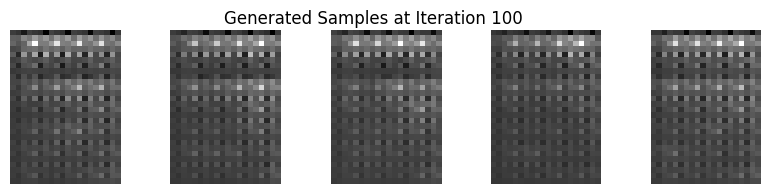

Iter 200/2000: Discriminator Loss: 0.1484, Generator Loss: 4.4530


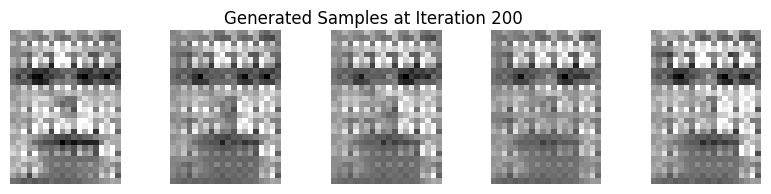

Iter 300/2000: Discriminator Loss: 0.2674, Generator Loss: 3.8155


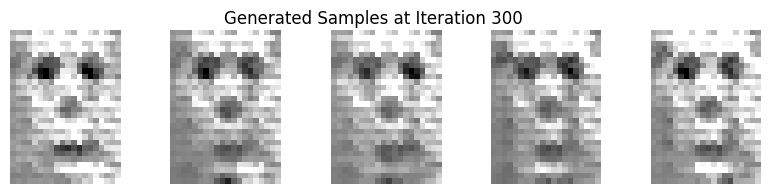

Iter 400/2000: Discriminator Loss: 0.2175, Generator Loss: 2.2137


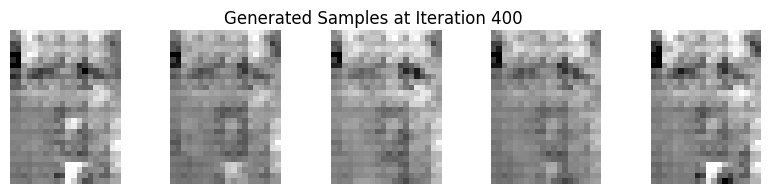

Iter 500/2000: Discriminator Loss: 0.3816, Generator Loss: 2.3766


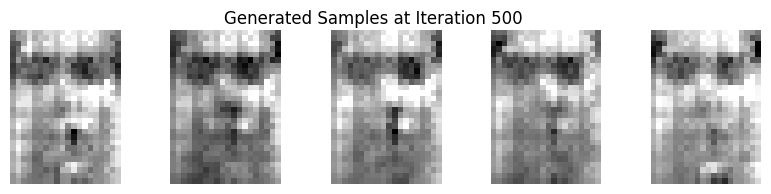

Iter 600/2000: Discriminator Loss: 0.4320, Generator Loss: 2.1901


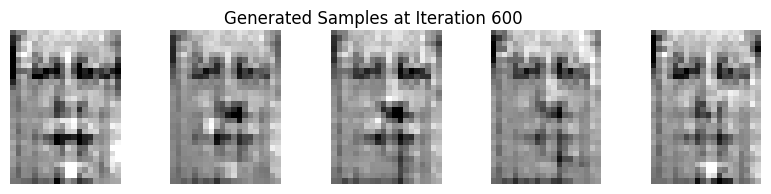

Iter 700/2000: Discriminator Loss: 0.6409, Generator Loss: 1.3600


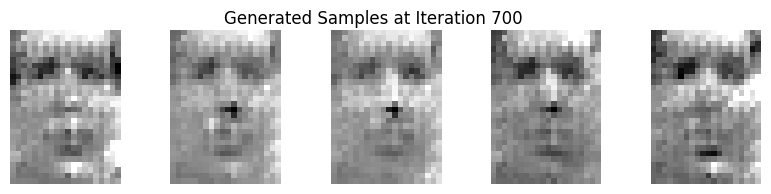

Iter 800/2000: Discriminator Loss: 0.2151, Generator Loss: 2.6106


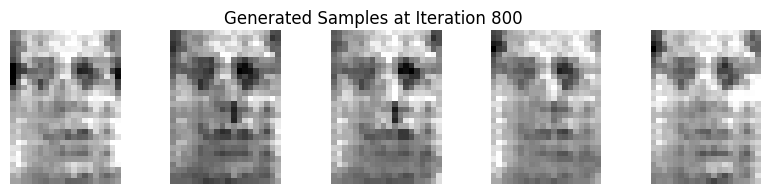

Iter 900/2000: Discriminator Loss: 0.2110, Generator Loss: 2.7634


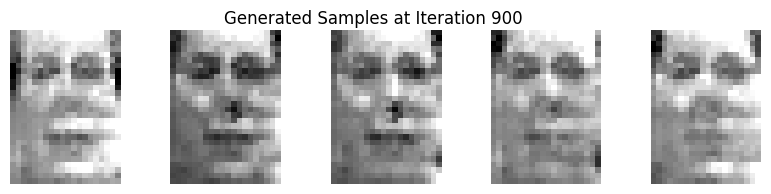

Iter 1000/2000: Discriminator Loss: 0.2775, Generator Loss: 2.1866


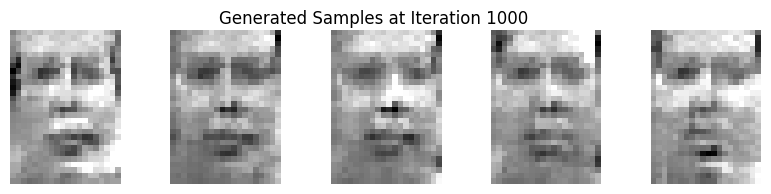

Iter 1100/2000: Discriminator Loss: 0.3202, Generator Loss: 2.1938


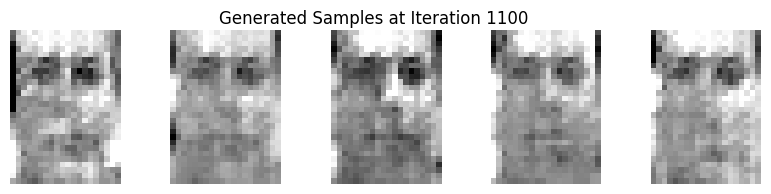

Iter 1200/2000: Discriminator Loss: 0.4292, Generator Loss: 1.4540


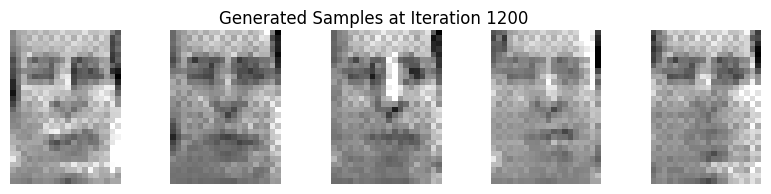

Iter 1300/2000: Discriminator Loss: 0.3782, Generator Loss: 1.9560


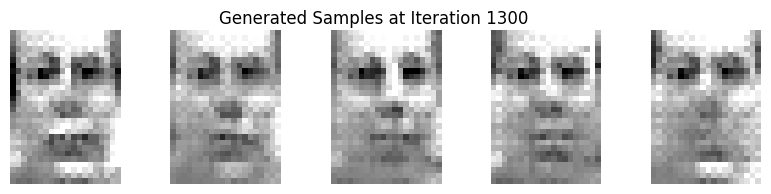

Iter 1400/2000: Discriminator Loss: 0.2736, Generator Loss: 1.9458


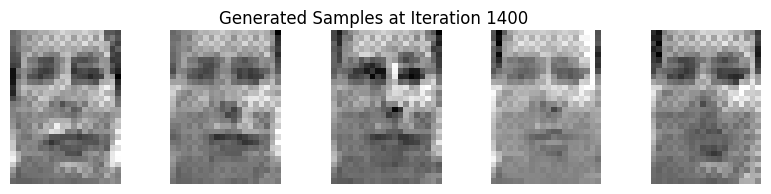

Iter 1500/2000: Discriminator Loss: 0.2602, Generator Loss: 2.1818


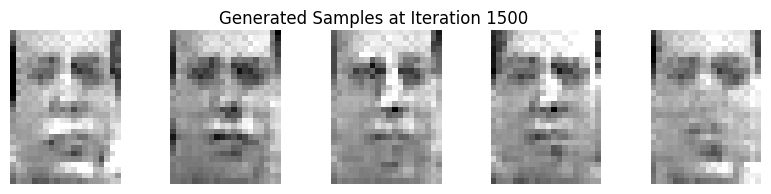

Iter 1600/2000: Discriminator Loss: 0.3838, Generator Loss: 1.5973


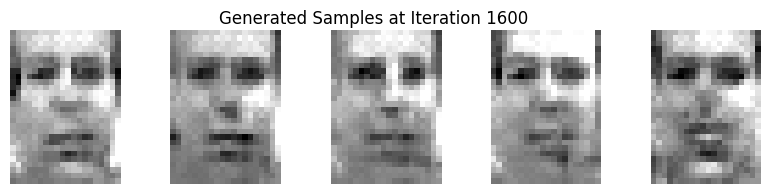

Iter 1700/2000: Discriminator Loss: 0.2687, Generator Loss: 1.9438


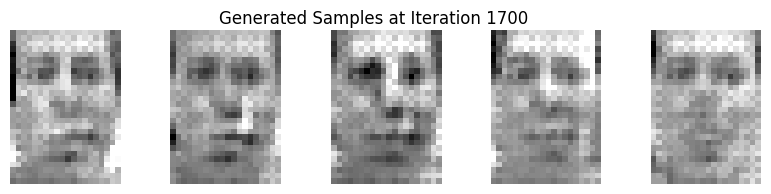

Iter 1800/2000: Discriminator Loss: 0.4817, Generator Loss: 1.8319


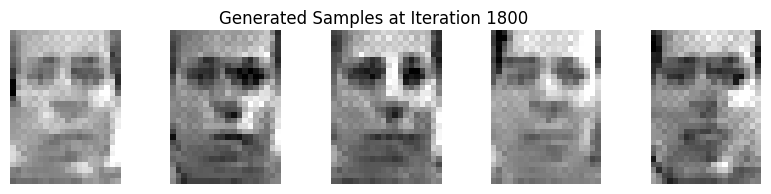

Iter 1900/2000: Discriminator Loss: 0.3467, Generator Loss: 2.1938


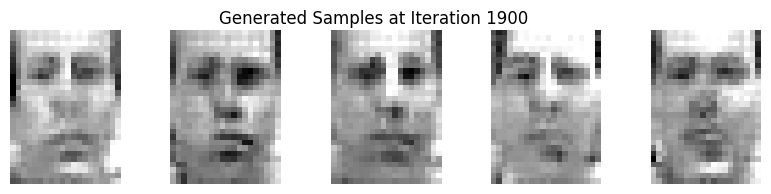

Iter 2000/2000: Discriminator Loss: 0.3460, Generator Loss: 1.6515


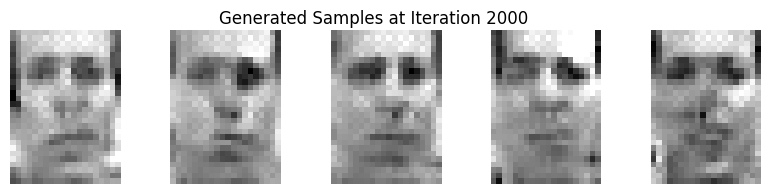


Training finished.


In [8]:
for iter_count in range(num_iter):
    # Select a random batch of real images
    inds = np.random.randint(0, x_train.shape[0], size=batch_size)
    x_real = x_train[inds]
    y_real = np.ones((batch_size, 1)) # Labels for real images: 1

    # Generate a batch of fake images
    random_latent_batch = np.random.uniform(-1, 1, size=(batch_size, latent_dim))
    x_fake = generator.predict(random_latent_batch, batch_size=batch_size, verbose=0)
    y_fake = np.zeros((batch_size, 1)) # Labels for fake images: 0

    # Discriminator loss
    with tf.GradientTape() as tape:
        pred_real = discriminator(x_real, training=True)
        real_loss = tf.reduce_mean(loss_fn(y_real, pred_real))

        pred_fake = discriminator(x_fake, training=True)
        fake_loss = tf.reduce_mean(loss_fn(y_fake, pred_fake))
        discrim_loss = 0.5 * (real_loss + fake_loss)

    # Compute gradients and update discriminator weights
    grads = tape.gradient(discrim_loss, discriminator.trainable_variables)
    d_opt.apply_gradients(zip(grads, discriminator.trainable_variables))

    # Generate a new batch of latent vectors
    random_latent_batch_for_gen = np.random.uniform(-1, 1, size=(batch_size, latent_dim))
    # Target labels for generator: we want discriminator to think these are real (label 1)
    y_gen_target = np.ones((batch_size, 1))

    # Generator loss
    with tf.GradientTape() as tape:
        x_gen = generator(random_latent_batch_for_gen, training=True)
        # Discriminator's weights are frozen during generator update (handled by tape.gradient target)
        pred_gen_for_loss = discriminator(x_gen, training=False) # As per example, D is fixed here
        gen_loss = tf.reduce_mean(loss_fn(y_gen_target, pred_gen_for_loss))

    # Compute gradients and update generator weights
    grads = tape.gradient(gen_loss, generator.trainable_variables)
    g_opt.apply_gradients(zip(grads, generator.trainable_variables))

    # Log losses
    gen_loss_history.append(gen_loss.numpy())
    discrim_loss_history.append(discrim_loss.numpy())

    # Periodic summary output and generator sample visualization
    if (iter_count + 1) % 100 == 0:
        print('Iter %d/%d: Discriminator Loss: %.4f, Generator Loss: %.4f' % (
            iter_count + 1, num_iter, discrim_loss.numpy(), gen_loss.numpy()))

        x_gen_samples = generator.predict(latent_vectors_for_viz, verbose=0)

        plt.figure(figsize=(num_samples_to_show * 2, 2))
        for i in range(num_samples_to_show):
            plt.subplot(1, num_samples_to_show, i + 1)
            # De-normalize for display: from [-1, 1] to [0, 1]
            img_display = (np.squeeze(x_gen_samples[i]) + 1.0) / 2.0
            plt.imshow(np.clip(img_display, 0.0, 1.0)) # Clip to ensure valid range for imshow
            plt.axis('off')
        plt.suptitle(f'Generated Samples at Iteration {iter_count + 1}')
        plt.show()

print("\nTraining finished.")

### Plotting Loss Curves

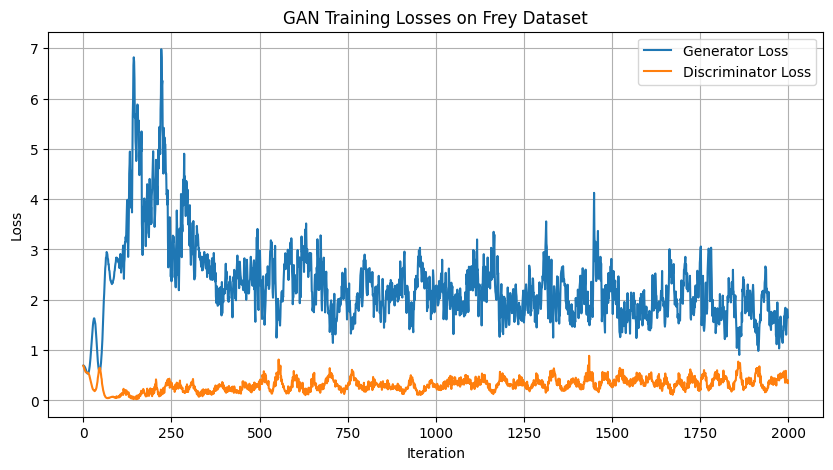

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(gen_loss_history, label='Generator Loss')
plt.plot(discrim_loss_history, label='Discriminator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('GAN Training Losses on Frey Dataset')
plt.legend()
plt.grid(True)
plt.show()

### Generating and Showing Final Images
Let's generate a batch of new images using the trained generator.


Generating some final samples...


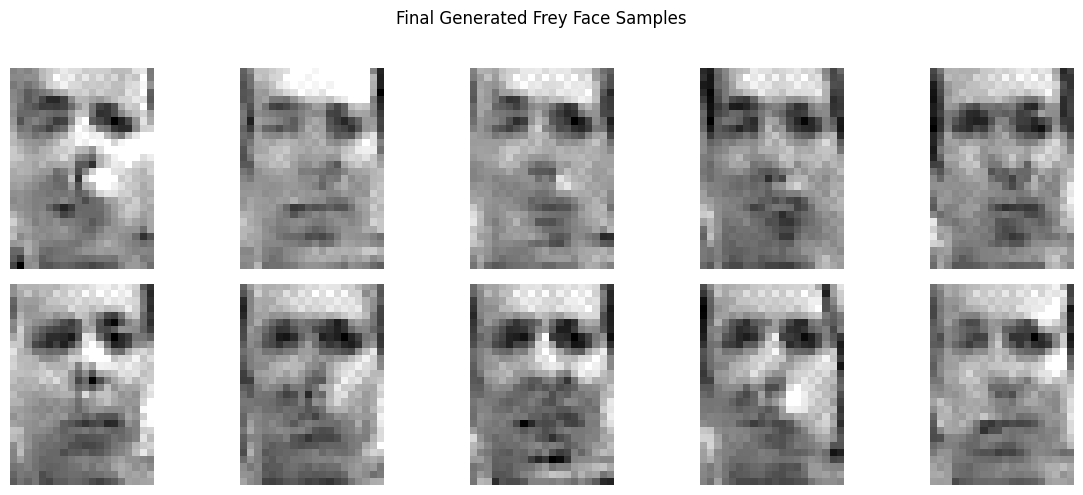

In [10]:
print("\nGenerating some final samples...")
num_final_samples = 10
# Ensure latent_dim is defined
final_latent_vectors = np.random.uniform(-1, 1, size=(num_final_samples, latent_dim))
final_samples = generator.predict(final_latent_vectors, verbose=0)

plt.figure(figsize=(12, 5)) # Adjusted for 2 rows of 5, or 1 row of 10
for i in range(num_final_samples):
    plt.subplot(2, 5, i + 1) # Assumes 10 samples to fit 2x5 grid
    img_display = (np.squeeze(final_samples[i]) + 1.0) / 2.0 # De-normalize
    plt.imshow(np.clip(img_display, 0.0, 1.0))
    plt.axis('off')
plt.suptitle('Final Generated Frey Face Samples')
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to prevent suptitle overlap
plt.show()

The generation does seem to have roughly converged, at least stopped improving. 

Generating 20 images from random latent vectors...
Displaying randomly generated samples:


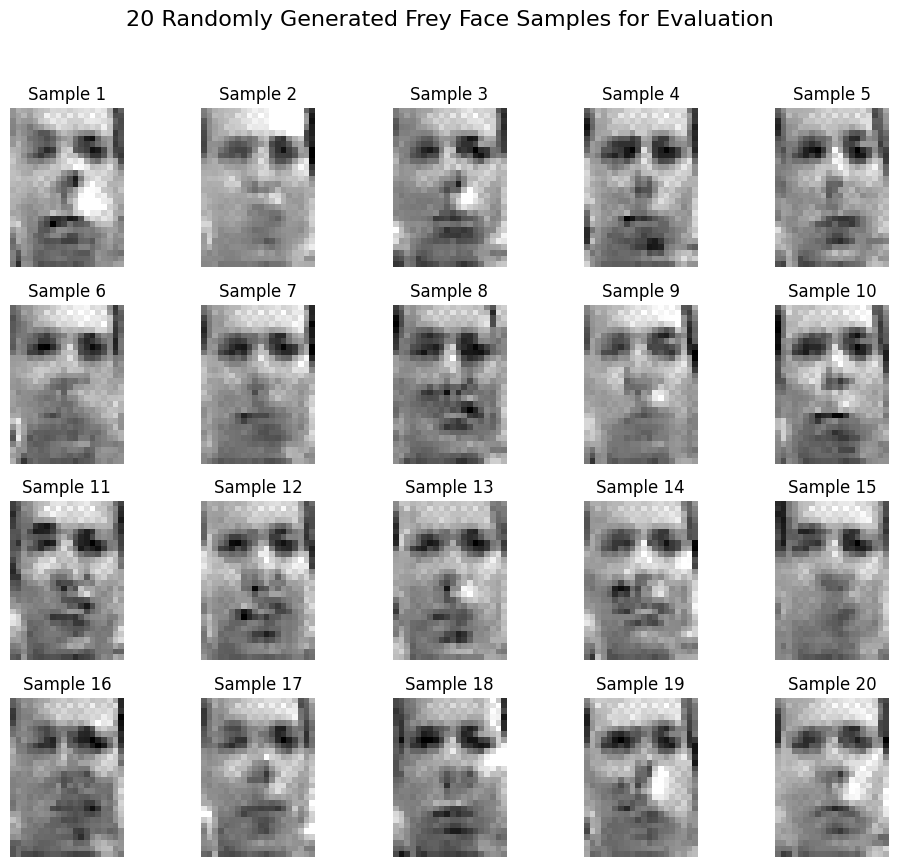


For reference, a few examples from the training dataset:


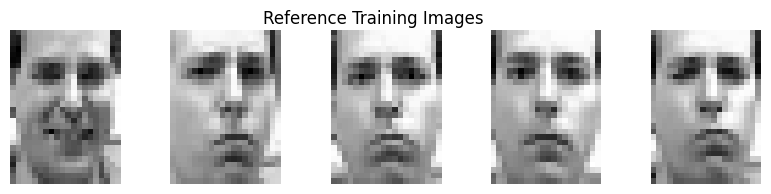

In [ ]:
num_eval_samples = 20  # Generate a decent number of samples for evaluation

# Sample random latent vectors from the [-1, 1] box
random_latent_vectors_eval = np.random.uniform(-1, 1, size=(num_eval_samples, latent_dim))

# Generate images
print(f"Generating {num_eval_samples} images from random latent vectors...")
generated_images_eval = generator.predict(random_latent_vectors_eval, verbose=0)

# Display the generated images
print("Displaying randomly generated samples:")
cols = 5  # Number of columns in the plot
rows = (num_eval_samples + cols - 1) // cols # Calculate rows needed
plt.figure(figsize=(cols * 2, rows * 2.2)) # Adjust figure size

for i in range(num_eval_samples):
    plt.subplot(rows, cols, i + 1)
    # De-normalize for display: from [-1, 1] to [0, 1]
    img_display = (np.squeeze(generated_images_eval[i]) + 1.0) / 2.0
    plt.imshow(np.clip(img_display, 0.0, 1.0)) # Clip to ensure valid range
    plt.axis('off')
    plt.title(f"Sample {i+1}")

plt.suptitle(f'{num_eval_samples} Randomly Generated Frey Face Samples for Evaluation', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout
plt.show()

# For comparison, you might want to show some actual training images again
print("\nFor reference, a few examples from the training dataset:")
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img_display = (x_train[np.random.randint(0, len(x_train))] + 1.0) / 2.0 # Show random training images
    plt.imshow(np.squeeze(img_display))
    plt.axis('off')
plt.suptitle("Reference Training Images")
plt.show()

They look fairly similar, but there are problems. Specifically, the nose to mouth area struggles to have defining features and things get merged together. 

Frey dataset loaded: (1965, 28, 20, 1)


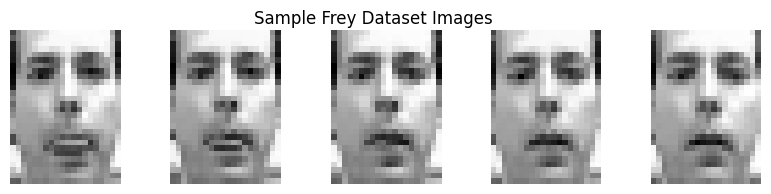

In [12]:
def get_frey_data():
    try:
        path = get_file('frey_rawface.mat',
                        'https://www.dropbox.com/scl/fi/m70sh4ef39pvy01czc63r/frey_rawface.mat?rlkey=5v6meiap55z68ada2roxwxuql&dl=1',
                        cache_subdir='datasets')
        data = np.transpose(loadmat(path)['ff'])
        x_train_frey = np.reshape(data, (-1, 28, 20, 1))
        x_train_frey = x_train_frey.astype('float32')
        x_train_frey /= 255.0  # Normalize to [0, 1]
        x_train_frey = (x_train_frey * 2.0) - 1.0  # Normalize to [-1, 1]
        return x_train_frey
    except Exception as e:
        print(f"Error loading Frey dataset: {e}")
        return None

x_train_frey = get_frey_data()

IMG_H, IMG_W, IMG_C = x_train_frey.shape[1:]
FLAT_DIM = IMG_H * IMG_W * IMG_C
print(f"Frey dataset loaded: {x_train_frey.shape}")

# Display a few example images
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img_display = (x_train_frey[i] + 1.0) / 2.0 # De-normalize for display
    plt.imshow(np.squeeze(img_display))
    plt.axis('off')
plt.suptitle("Sample Frey Dataset Images")
plt.show()

Encoder Summary:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 20, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 560)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        71,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,194 (313.26 KB)

 Trainable params: 80,194 (313.26 KB)

 Non-trainable params: 0 (0.00 B)


Decoder Summary:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 560)            │        72,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Reshape)        │ (None, 28, 20, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,752 (315.44 KB)

 Trainable params: 80,752 (315.44 KB)

 Non-trainable params: 0 (0.00 B)


Autoencoder Summary:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 28, 20, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │        80,194 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 20, 1)      │        80,752 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,946 (628.70 KB)

 Trainable params: 160,946 (628.70 KB)

 Non-trainable params: 0 (0.00 B)


Training Autoencoder for 50 epochs...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0975 - val_loss: 0.0438
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0371 - val_loss: 0.0387
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0321 - val_loss: 0.0358
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0307 - val_loss: 0.0351
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0299 - val_loss: 0.0347
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0292 - val_loss: 0.0365
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0289 - val_loss: 0.0363
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0290 - val_loss: 0.0360
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0279 - val_loss: 0.0352
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277 - val_loss: 0.0359
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277 - val_loss: 0.0358
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━

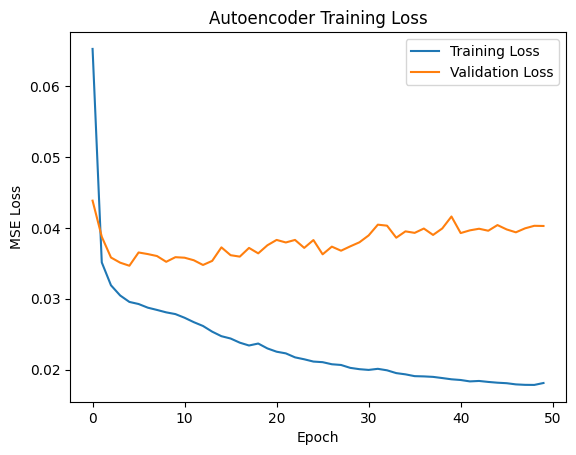

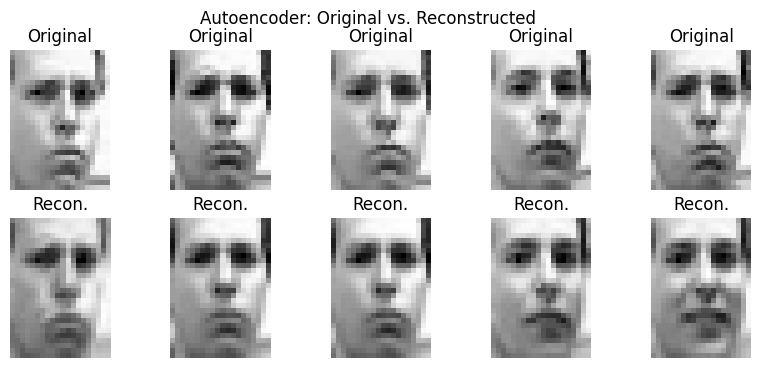


Extracting latent embeddings from the training set...
Shape of latent embeddings: (1965, 2)


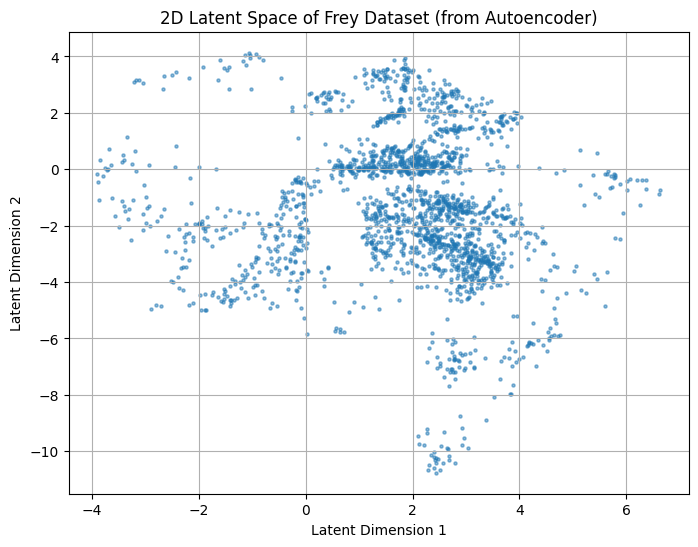

In [19]:
LATENT_DIM_AE = 2 # Bottleneck dimensionality

# Define Encoder
encoder_inputs = layers.Input(shape=(IMG_H, IMG_W, IMG_C), name='encoder_input')
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
encoder_outputs = layers.Dense(LATENT_DIM_AE, activation=None, name='encoder_output')(x) # Linear activation for bottleneck
encoder = Model(encoder_inputs, encoder_outputs, name='encoder')
print("Encoder Summary:")
encoder.summary()

# Define Decoder
decoder_inputs = layers.Input(shape=(LATENT_DIM_AE,), name='decoder_input')
x = layers.Dense(64, activation='relu')(decoder_inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(FLAT_DIM, activation='tanh')(x) # Tanh because input images are [-1, 1]
decoder_outputs = layers.Reshape((IMG_H, IMG_W, IMG_C), name='decoder_output')(x)
decoder = Model(decoder_inputs, decoder_outputs, name='decoder')
print("\nDecoder Summary:")
decoder.summary()

# Define Autoencoder
autoencoder_inputs = layers.Input(shape=(IMG_H, IMG_W, IMG_C), name='ae_input')
encoded = encoder(autoencoder_inputs)
decoded = decoder(encoded)
autoencoder = Model(autoencoder_inputs, decoded, name='autoencoder')
print("\nAutoencoder Summary:")
autoencoder.summary()

# Compile and Train Autoencoder
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

ae_epochs = 50 # Adjust as needed; might need more for good reconstruction
ae_batch_size = 32

print(f"\nTraining Autoencoder for {ae_epochs} epochs...")
history_ae = autoencoder.fit(x_train_frey, x_train_frey,
                                epochs=ae_epochs,
                                batch_size=ae_batch_size,
                                shuffle=True,
                                validation_split=0.1, # Optional: use a validation split
                                verbose=1) # Set to 1 or 2 for progress, 0 for silent

# Plot training loss
plt.figure()
plt.plot(history_ae.history['loss'], label='Training Loss')
if 'val_loss' in history_ae.history:
    plt.plot(history_ae.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Display some original and reconstructed images
num_display = 5
random_indices = np.random.choice(len(x_train_frey), num_display, replace=False)
originals = x_train_frey[random_indices]
reconstructions = autoencoder.predict(originals, verbose=0)

plt.figure(figsize=(num_display * 2, 4))
for i in range(num_display):
    # Original
    plt.subplot(2, num_display, i + 1)
    plt.imshow(np.squeeze((originals[i] + 1.0) / 2.0))
    plt.title("Original")
    plt.axis('off')
    # Reconstruction
    plt.subplot(2, num_display, num_display + i + 1)
    plt.imshow(np.squeeze((reconstructions[i] + 1.0) / 2.0))
    plt.title("Recon.")
    plt.axis('off')
plt.suptitle("Autoencoder: Original vs. Reconstructed")
plt.show()

# Extract and store latent embeddings for the training set
print("\nExtracting latent embeddings from the training set...")
latent_embeddings_train = encoder.predict(x_train_frey, batch_size=ae_batch_size, verbose=0)
print(f"Shape of latent embeddings: {latent_embeddings_train.shape}") # Should be (num_frey_images, 2)

# Plot the 2D latent space
plt.figure(figsize=(8, 6))
plt.scatter(latent_embeddings_train[:, 0], latent_embeddings_train[:, 1], s=5, alpha=0.5)
plt.title('2D Latent Space of Frey Dataset (from Autoencoder)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

Diffusion Model (MLP for Latents) Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ timestep_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 128)    │    128,000 │ timestep_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_input        │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 128)       │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 130)       │          0 │ latent_input[0][… │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     16,768 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     16,512 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     16,512 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 2)         │        258 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 178,050 (695.51 KB)

 Trainable params: 178,050 (695.51 KB)

 Non-trainable params: 0 (0.00 B)


Training Diffusion Model on Latent Embeddings for 150 epochs...


Epoch 1/150:   0%|          | 0/16 [02:56<?, ?it/s]
2025-05-21 17:49:22.840244: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 1/150: 100%|██████████| 16/16 [00:00<00:00, 39.30it/s, Loss: 0.7160]


Epoch 1, Average Loss: 0.9000


Epoch 2/150: 100%|██████████| 16/16 [00:00<00:00, 51.57it/s, Loss: 0.6884]


Epoch 2, Average Loss: 0.8082


Epoch 3/150: 100%|██████████| 16/16 [00:00<00:00, 51.26it/s, Loss: 0.6672]


Epoch 3, Average Loss: 0.7215


Epoch 4/150: 100%|██████████| 16/16 [00:00<00:00, 49.82it/s, Loss: 0.5183]


Epoch 4, Average Loss: 0.6739


Epoch 5/150: 100%|██████████| 16/16 [00:00<00:00, 51.49it/s, Loss: 0.6100]


Epoch 5, Average Loss: 0.6348


Epoch 6/150: 100%|██████████| 16/16 [00:00<00:00, 42.09it/s, Loss: 0.7230]


Epoch 6, Average Loss: 0.6478


Epoch 7/150: 100%|██████████| 16/16 [00:00<00:00, 47.72it/s, Loss: 0.4873]


Epoch 7, Average Loss: 0.6044


Epoch 8/150: 100%|██████████| 16/16 [00:00<00:00, 48.95it/s, Loss: 0.6994]


Epoch 8, Average Loss: 0.5993


Epoch 9/150: 100%|██████████| 16/16 [00:00<00:00, 45.83it/s, Loss: 0.5525]


Epoch 9, Average Loss: 0.5999


Epoch 10/150: 100%|██████████| 16/16 [00:00<00:00, 46.69it/s, Loss: 0.4500]


Epoch 10, Average Loss: 0.6249


Epoch 11/150: 100%|██████████| 16/16 [00:00<00:00, 48.60it/s, Loss: 0.5908]


Epoch 11, Average Loss: 0.6160


Epoch 12/150: 100%|██████████| 16/16 [00:00<00:00, 47.54it/s, Loss: 0.6659]


Epoch 12, Average Loss: 0.5700


Epoch 13/150: 100%|██████████| 16/16 [00:00<00:00, 41.98it/s, Loss: 0.5271]


Epoch 13, Average Loss: 0.5625


Epoch 14/150: 100%|██████████| 16/16 [00:00<00:00, 47.50it/s, Loss: 1.0294]


Epoch 14, Average Loss: 0.5551


Epoch 15/150: 100%|██████████| 16/16 [00:00<00:00, 46.96it/s, Loss: 0.3769]


Epoch 15, Average Loss: 0.5327


Epoch 16/150: 100%|██████████| 16/16 [00:00<00:00, 46.52it/s, Loss: 0.5343]


Epoch 16, Average Loss: 0.5249


Epoch 17/150: 100%|██████████| 16/16 [00:00<00:00, 46.60it/s, Loss: 0.4136]


Epoch 17, Average Loss: 0.4905


Epoch 18/150: 100%|██████████| 16/16 [00:00<00:00, 47.02it/s, Loss: 0.5717]


Epoch 18, Average Loss: 0.4675


Epoch 19/150: 100%|██████████| 16/16 [00:00<00:00, 44.56it/s, Loss: 0.3535]


Epoch 19, Average Loss: 0.4439


Epoch 20/150: 100%|██████████| 16/16 [00:00<00:00, 41.97it/s, Loss: 0.4244]


Epoch 20, Average Loss: 0.4552


Epoch 21/150: 100%|██████████| 16/16 [00:00<00:00, 46.67it/s, Loss: 0.3763]


Epoch 21, Average Loss: 0.4312


Epoch 22/150: 100%|██████████| 16/16 [00:00<00:00, 46.30it/s, Loss: 0.5470]


Epoch 22, Average Loss: 0.4338


Epoch 23/150: 100%|██████████| 16/16 [00:00<00:00, 47.37it/s, Loss: 0.2886]


Epoch 23, Average Loss: 0.4621


Epoch 24/150: 100%|██████████| 16/16 [00:00<00:00, 46.85it/s, Loss: 0.6034]


Epoch 24, Average Loss: 0.4294


Epoch 25/150: 100%|██████████| 16/16 [00:00<00:00, 41.61it/s, Loss: 0.3871]


Epoch 25, Average Loss: 0.4075


Epoch 26/150: 100%|██████████| 16/16 [00:00<00:00, 47.63it/s, Loss: 0.4527]


Epoch 26, Average Loss: 0.4279


Epoch 27/150: 100%|██████████| 16/16 [00:00<00:00, 46.83it/s, Loss: 0.3438]


Epoch 27, Average Loss: 0.4591


Epoch 28/150: 100%|██████████| 16/16 [00:00<00:00, 45.52it/s, Loss: 0.4528]


Epoch 28, Average Loss: 0.4067


Epoch 29/150: 100%|██████████| 16/16 [00:00<00:00, 46.79it/s, Loss: 0.3850]


Epoch 29, Average Loss: 0.4341


Epoch 30/150: 100%|██████████| 16/16 [00:00<00:00, 47.88it/s, Loss: 0.4088]


Epoch 30, Average Loss: 0.4090


Epoch 31/150: 100%|██████████| 16/16 [00:00<00:00, 47.85it/s, Loss: 0.3906]


Epoch 31, Average Loss: 0.4115


Epoch 32/150: 100%|██████████| 16/16 [00:00<00:00, 44.27it/s, Loss: 0.3545]


Epoch 32, Average Loss: 0.4246


Epoch 33/150: 100%|██████████| 16/16 [00:00<00:00, 47.81it/s, Loss: 0.3578]


Epoch 33, Average Loss: 0.4065


Epoch 34/150: 100%|██████████| 16/16 [00:00<00:00, 49.16it/s, Loss: 0.3910]


Epoch 34, Average Loss: 0.3926


Epoch 35/150: 100%|██████████| 16/16 [00:00<00:00, 48.52it/s, Loss: 0.4152]


Epoch 35, Average Loss: 0.4239


Epoch 36/150: 100%|██████████| 16/16 [00:00<00:00, 47.53it/s, Loss: 0.2703]


Epoch 36, Average Loss: 0.4144


Epoch 37/150: 100%|██████████| 16/16 [00:00<00:00, 42.09it/s, Loss: 0.4236]


Epoch 37, Average Loss: 0.3830


Epoch 38/150: 100%|██████████| 16/16 [00:00<00:00, 50.34it/s, Loss: 0.2783]


Epoch 38, Average Loss: 0.4031


Epoch 39/150: 100%|██████████| 16/16 [00:00<00:00, 49.27it/s, Loss: 0.2495]


Epoch 39, Average Loss: 0.3964


Epoch 40/150: 100%|██████████| 16/16 [00:00<00:00, 50.00it/s, Loss: 0.4339]


Epoch 40, Average Loss: 0.4100


Epoch 41/150: 100%|██████████| 16/16 [00:00<00:00, 50.21it/s, Loss: 0.4018]


Epoch 41, Average Loss: 0.4197


Epoch 42/150: 100%|██████████| 16/16 [00:00<00:00, 51.64it/s, Loss: 0.3645]


Epoch 42, Average Loss: 0.4037


Epoch 43/150: 100%|██████████| 16/16 [00:00<00:00, 49.51it/s, Loss: 0.3681]


Epoch 43, Average Loss: 0.4095


Epoch 44/150: 100%|██████████| 16/16 [00:00<00:00, 44.03it/s, Loss: 0.3531]


Epoch 44, Average Loss: 0.3959


Epoch 45/150: 100%|██████████| 16/16 [00:00<00:00, 46.58it/s, Loss: 0.4992]


Epoch 45, Average Loss: 0.4112


Epoch 46/150: 100%|██████████| 16/16 [00:00<00:00, 47.60it/s, Loss: 0.5125]


Epoch 46, Average Loss: 0.4138


Epoch 47/150: 100%|██████████| 16/16 [00:00<00:00, 48.26it/s, Loss: 0.4363]


Epoch 47, Average Loss: 0.4004


Epoch 48/150: 100%|██████████| 16/16 [00:00<00:00, 36.04it/s, Loss: 0.3828]


Epoch 48, Average Loss: 0.4163


Epoch 49/150: 100%|██████████| 16/16 [00:00<00:00, 43.75it/s, Loss: 0.4909]


Epoch 49, Average Loss: 0.4298


Epoch 50/150: 100%|██████████| 16/16 [00:00<00:00, 47.54it/s, Loss: 0.5631]


Epoch 50, Average Loss: 0.4060


Epoch 51/150: 100%|██████████| 16/16 [00:00<00:00, 47.35it/s, Loss: 0.3476]


Epoch 51, Average Loss: 0.3820


Epoch 52/150: 100%|██████████| 16/16 [00:00<00:00, 48.99it/s, Loss: 0.5081]


Epoch 52, Average Loss: 0.4185


Epoch 53/150: 100%|██████████| 16/16 [00:00<00:00, 49.21it/s, Loss: 0.4797]


Epoch 53, Average Loss: 0.4036


Epoch 54/150: 100%|██████████| 16/16 [00:00<00:00, 49.22it/s, Loss: 0.4559]


Epoch 54, Average Loss: 0.3973


Epoch 55/150: 100%|██████████| 16/16 [00:00<00:00, 43.74it/s, Loss: 0.3942]


Epoch 55, Average Loss: 0.3943


Epoch 56/150: 100%|██████████| 16/16 [00:00<00:00, 47.37it/s, Loss: 0.3547]


Epoch 56, Average Loss: 0.4072


Epoch 57/150: 100%|██████████| 16/16 [00:00<00:00, 48.80it/s, Loss: 0.2724]


Epoch 57, Average Loss: 0.4034


Epoch 58/150: 100%|██████████| 16/16 [00:00<00:00, 48.05it/s, Loss: 0.3535]


Epoch 58, Average Loss: 0.3872


Epoch 59/150: 100%|██████████| 16/16 [00:00<00:00, 48.63it/s, Loss: 0.5095]


Epoch 59, Average Loss: 0.4212


Epoch 60/150: 100%|██████████| 16/16 [00:00<00:00, 48.77it/s, Loss: 0.5114]


Epoch 60, Average Loss: 0.4049


Epoch 61/150: 100%|██████████| 16/16 [00:00<00:00, 49.69it/s, Loss: 0.4536]


Epoch 61, Average Loss: 0.3999


Epoch 62/150: 100%|██████████| 16/16 [00:00<00:00, 45.04it/s, Loss: 0.5538]


Epoch 62, Average Loss: 0.3996


Epoch 63/150: 100%|██████████| 16/16 [00:00<00:00, 48.60it/s, Loss: 0.4508]


Epoch 63, Average Loss: 0.4057


Epoch 64/150: 100%|██████████| 16/16 [00:00<00:00, 47.98it/s, Loss: 0.3124]


Epoch 64, Average Loss: 0.3900


Epoch 65/150: 100%|██████████| 16/16 [00:00<00:00, 48.86it/s, Loss: 0.3768]


Epoch 65, Average Loss: 0.3945


Epoch 66/150: 100%|██████████| 16/16 [00:00<00:00, 50.14it/s, Loss: 0.5620]


Epoch 66, Average Loss: 0.4204


Epoch 67/150: 100%|██████████| 16/16 [00:00<00:00, 49.38it/s, Loss: 0.3400]


Epoch 67, Average Loss: 0.4075


Epoch 68/150: 100%|██████████| 16/16 [00:00<00:00, 49.44it/s, Loss: 0.4062]


Epoch 68, Average Loss: 0.3910


Epoch 69/150: 100%|██████████| 16/16 [00:00<00:00, 45.49it/s, Loss: 0.4447]


Epoch 69, Average Loss: 0.4087


Epoch 70/150: 100%|██████████| 16/16 [00:00<00:00, 48.20it/s, Loss: 0.3140]


Epoch 70, Average Loss: 0.4132


Epoch 71/150: 100%|██████████| 16/16 [00:00<00:00, 52.10it/s, Loss: 0.3908]


Epoch 71, Average Loss: 0.4295


Epoch 72/150: 100%|██████████| 16/16 [00:00<00:00, 50.28it/s, Loss: 0.5056]


Epoch 72, Average Loss: 0.4159


Epoch 73/150: 100%|██████████| 16/16 [00:00<00:00, 50.97it/s, Loss: 0.5149]


Epoch 73, Average Loss: 0.3996


Epoch 74/150: 100%|██████████| 16/16 [00:00<00:00, 50.21it/s, Loss: 0.4954]


Epoch 74, Average Loss: 0.4082


Epoch 75/150: 100%|██████████| 16/16 [00:00<00:00, 48.01it/s, Loss: 0.4211]


Epoch 75, Average Loss: 0.4149


Epoch 76/150: 100%|██████████| 16/16 [00:00<00:00, 45.23it/s, Loss: 0.4551]


Epoch 76, Average Loss: 0.4104


Epoch 77/150: 100%|██████████| 16/16 [00:00<00:00, 50.13it/s, Loss: 0.3023]


Epoch 77, Average Loss: 0.3869


Epoch 78/150: 100%|██████████| 16/16 [00:00<00:00, 49.54it/s, Loss: 0.2454]


Epoch 78, Average Loss: 0.3881


Epoch 79/150: 100%|██████████| 16/16 [00:00<00:00, 51.61it/s, Loss: 0.2538]


Epoch 79, Average Loss: 0.3813


Epoch 80/150: 100%|██████████| 16/16 [00:00<00:00, 49.10it/s, Loss: 0.3654]


Epoch 80, Average Loss: 0.3794


Epoch 81/150: 100%|██████████| 16/16 [00:00<00:00, 50.64it/s, Loss: 0.4429]


Epoch 81, Average Loss: 0.3899


Epoch 82/150: 100%|██████████| 16/16 [00:00<00:00, 50.48it/s, Loss: 0.4909]


Epoch 82, Average Loss: 0.4155


Epoch 83/150: 100%|██████████| 16/16 [00:00<00:00, 44.92it/s, Loss: 0.4016]


Epoch 83, Average Loss: 0.3944


Epoch 84/150: 100%|██████████| 16/16 [00:00<00:00, 48.95it/s, Loss: 0.2176]


Epoch 84, Average Loss: 0.3717


Epoch 85/150: 100%|██████████| 16/16 [00:00<00:00, 49.16it/s, Loss: 0.2794]


Epoch 85, Average Loss: 0.3767


Epoch 86/150: 100%|██████████| 16/16 [00:00<00:00, 47.52it/s, Loss: 0.4013]


Epoch 86, Average Loss: 0.4297


Epoch 87/150: 100%|██████████| 16/16 [00:00<00:00, 48.97it/s, Loss: 0.3953]


Epoch 87, Average Loss: 0.4062


Epoch 88/150: 100%|██████████| 16/16 [00:00<00:00, 48.49it/s, Loss: 0.4400]


Epoch 88, Average Loss: 0.4040


Epoch 89/150: 100%|██████████| 16/16 [00:00<00:00, 48.49it/s, Loss: 0.3969]


Epoch 89, Average Loss: 0.3866


Epoch 90/150: 100%|██████████| 16/16 [00:00<00:00, 45.75it/s, Loss: 0.3322]


Epoch 90, Average Loss: 0.4099


Epoch 91/150: 100%|██████████| 16/16 [00:00<00:00, 50.35it/s, Loss: 0.1778]


Epoch 91, Average Loss: 0.3948


Epoch 92/150: 100%|██████████| 16/16 [00:00<00:00, 49.75it/s, Loss: 0.5215]


Epoch 92, Average Loss: 0.4224


Epoch 93/150: 100%|██████████| 16/16 [00:00<00:00, 49.26it/s, Loss: 0.5303]


Epoch 93, Average Loss: 0.3972


Epoch 94/150: 100%|██████████| 16/16 [00:00<00:00, 50.10it/s, Loss: 0.6430]


Epoch 94, Average Loss: 0.3887


Epoch 95/150: 100%|██████████| 16/16 [00:00<00:00, 48.04it/s, Loss: 0.4489]


Epoch 95, Average Loss: 0.4205


Epoch 96/150: 100%|██████████| 16/16 [00:00<00:00, 47.19it/s, Loss: 0.3245]


Epoch 96, Average Loss: 0.4086


Epoch 97/150: 100%|██████████| 16/16 [00:00<00:00, 43.30it/s, Loss: 0.2846]


Epoch 97, Average Loss: 0.4186


Epoch 98/150: 100%|██████████| 16/16 [00:00<00:00, 48.32it/s, Loss: 0.2827]


Epoch 98, Average Loss: 0.4086


Epoch 99/150: 100%|██████████| 16/16 [00:00<00:00, 47.60it/s, Loss: 0.4699]


Epoch 99, Average Loss: 0.4129


Epoch 100/150: 100%|██████████| 16/16 [00:00<00:00, 48.79it/s, Loss: 0.3987]


Epoch 100, Average Loss: 0.3849


Epoch 101/150: 100%|██████████| 16/16 [00:00<00:00, 50.20it/s, Loss: 0.3471]


Epoch 101, Average Loss: 0.3932


Epoch 102/150: 100%|██████████| 16/16 [00:00<00:00, 47.59it/s, Loss: 0.2898]


Epoch 102, Average Loss: 0.4093


Epoch 103/150: 100%|██████████| 16/16 [00:00<00:00, 49.69it/s, Loss: 0.4296]


Epoch 103, Average Loss: 0.4083


Epoch 104/150: 100%|██████████| 16/16 [00:00<00:00, 44.58it/s, Loss: 0.3866]


Epoch 104, Average Loss: 0.3939


Epoch 105/150: 100%|██████████| 16/16 [00:00<00:00, 48.29it/s, Loss: 0.4066]


Epoch 105, Average Loss: 0.4070


Epoch 106/150: 100%|██████████| 16/16 [00:00<00:00, 48.01it/s, Loss: 0.4822]


Epoch 106, Average Loss: 0.3912


Epoch 107/150: 100%|██████████| 16/16 [00:00<00:00, 49.17it/s, Loss: 0.3761]


Epoch 107, Average Loss: 0.3789


Epoch 108/150: 100%|██████████| 16/16 [00:00<00:00, 50.20it/s, Loss: 0.2415]


Epoch 108, Average Loss: 0.3927


Epoch 109/150: 100%|██████████| 16/16 [00:00<00:00, 49.39it/s, Loss: 0.3792]


Epoch 109, Average Loss: 0.3918


Epoch 110/150: 100%|██████████| 16/16 [00:00<00:00, 50.48it/s, Loss: 0.5150]


Epoch 110, Average Loss: 0.3984


Epoch 111/150: 100%|██████████| 16/16 [00:00<00:00, 43.78it/s, Loss: 0.4466]


Epoch 111, Average Loss: 0.3933


Epoch 112/150: 100%|██████████| 16/16 [00:00<00:00, 49.74it/s, Loss: 0.4537]


Epoch 112, Average Loss: 0.3922


Epoch 113/150: 100%|██████████| 16/16 [00:00<00:00, 47.13it/s, Loss: 0.3095]


Epoch 113, Average Loss: 0.3926


Epoch 114/150: 100%|██████████| 16/16 [00:00<00:00, 48.31it/s, Loss: 0.4284]


Epoch 114, Average Loss: 0.3951


Epoch 115/150: 100%|██████████| 16/16 [00:00<00:00, 46.71it/s, Loss: 0.3562]


Epoch 115, Average Loss: 0.3772


Epoch 116/150: 100%|██████████| 16/16 [00:00<00:00, 48.47it/s, Loss: 0.4245]


Epoch 116, Average Loss: 0.4064


Epoch 117/150: 100%|██████████| 16/16 [00:00<00:00, 47.10it/s, Loss: 0.3267]


Epoch 117, Average Loss: 0.3752


Epoch 118/150: 100%|██████████| 16/16 [00:00<00:00, 41.19it/s, Loss: 0.2750]


Epoch 118, Average Loss: 0.4067


Epoch 119/150: 100%|██████████| 16/16 [00:00<00:00, 47.73it/s, Loss: 0.3482]


Epoch 119, Average Loss: 0.3579


Epoch 120/150: 100%|██████████| 16/16 [00:00<00:00, 48.77it/s, Loss: 0.4690]


Epoch 120, Average Loss: 0.3990


Epoch 121/150: 100%|██████████| 16/16 [00:00<00:00, 48.26it/s, Loss: 0.2612]


Epoch 121, Average Loss: 0.4071


Epoch 122/150: 100%|██████████| 16/16 [00:00<00:00, 49.61it/s, Loss: 0.3938]


Epoch 122, Average Loss: 0.3881


Epoch 123/150: 100%|██████████| 16/16 [00:00<00:00, 46.92it/s, Loss: 0.2648]


Epoch 123, Average Loss: 0.3800


Epoch 124/150: 100%|██████████| 16/16 [00:00<00:00, 48.08it/s, Loss: 0.3807]


Epoch 124, Average Loss: 0.3739


Epoch 125/150: 100%|██████████| 16/16 [00:00<00:00, 42.94it/s, Loss: 0.5605]


Epoch 125, Average Loss: 0.4004


Epoch 126/150: 100%|██████████| 16/16 [00:00<00:00, 47.35it/s, Loss: 0.4806]


Epoch 126, Average Loss: 0.3832


Epoch 127/150: 100%|██████████| 16/16 [00:00<00:00, 49.73it/s, Loss: 0.3313]


Epoch 127, Average Loss: 0.3735


Epoch 128/150: 100%|██████████| 16/16 [00:00<00:00, 47.98it/s, Loss: 0.3597]


Epoch 128, Average Loss: 0.3860


Epoch 129/150: 100%|██████████| 16/16 [00:00<00:00, 47.96it/s, Loss: 0.4170]


Epoch 129, Average Loss: 0.3994


Epoch 130/150: 100%|██████████| 16/16 [00:00<00:00, 48.60it/s, Loss: 0.2188]


Epoch 130, Average Loss: 0.3730


Epoch 131/150: 100%|██████████| 16/16 [00:00<00:00, 48.69it/s, Loss: 0.3629]


Epoch 131, Average Loss: 0.4070


Epoch 132/150: 100%|██████████| 16/16 [00:00<00:00, 41.20it/s, Loss: 0.3376]


Epoch 132, Average Loss: 0.3910


Epoch 133/150: 100%|██████████| 16/16 [00:00<00:00, 48.43it/s, Loss: 0.2251]


Epoch 133, Average Loss: 0.3939


Epoch 134/150: 100%|██████████| 16/16 [00:00<00:00, 48.50it/s, Loss: 0.5918]


Epoch 134, Average Loss: 0.4154


Epoch 135/150: 100%|██████████| 16/16 [00:00<00:00, 49.10it/s, Loss: 0.2768]


Epoch 135, Average Loss: 0.3678


Epoch 136/150: 100%|██████████| 16/16 [00:00<00:00, 48.61it/s, Loss: 0.4494]


Epoch 136, Average Loss: 0.3875


Epoch 137/150: 100%|██████████| 16/16 [00:00<00:00, 49.39it/s, Loss: 0.2968]


Epoch 137, Average Loss: 0.4195


Epoch 138/150: 100%|██████████| 16/16 [00:00<00:00, 46.64it/s, Loss: 0.3194]


Epoch 138, Average Loss: 0.3737


Epoch 139/150: 100%|██████████| 16/16 [00:00<00:00, 44.46it/s, Loss: 0.4344]


Epoch 139, Average Loss: 0.3878


Epoch 140/150: 100%|██████████| 16/16 [00:00<00:00, 49.18it/s, Loss: 0.4381]


Epoch 140, Average Loss: 0.3971


Epoch 141/150: 100%|██████████| 16/16 [00:00<00:00, 49.47it/s, Loss: 0.2705]


Epoch 141, Average Loss: 0.3936


Epoch 142/150: 100%|██████████| 16/16 [00:00<00:00, 49.08it/s, Loss: 0.4257]


Epoch 142, Average Loss: 0.4083


Epoch 143/150: 100%|██████████| 16/16 [00:00<00:00, 49.57it/s, Loss: 0.2610]


Epoch 143, Average Loss: 0.3800


Epoch 144/150: 100%|██████████| 16/16 [00:00<00:00, 48.53it/s, Loss: 0.5402]


Epoch 144, Average Loss: 0.4015


Epoch 145/150: 100%|██████████| 16/16 [00:00<00:00, 48.01it/s, Loss: 0.4327]


Epoch 145, Average Loss: 0.3989


Epoch 146/150: 100%|██████████| 16/16 [00:00<00:00, 45.05it/s, Loss: 0.2082]


Epoch 146, Average Loss: 0.3734


Epoch 147/150: 100%|██████████| 16/16 [00:00<00:00, 48.52it/s, Loss: 0.5984]


Epoch 147, Average Loss: 0.3939


Epoch 148/150: 100%|██████████| 16/16 [00:00<00:00, 47.95it/s, Loss: 0.2684]


Epoch 148, Average Loss: 0.4005


Epoch 149/150: 100%|██████████| 16/16 [00:00<00:00, 51.46it/s, Loss: 0.3850]


Epoch 149, Average Loss: 0.4060


Epoch 150/150: 100%|██████████| 16/16 [00:00<00:00, 50.14it/s, Loss: 0.4017]


Epoch 150, Average Loss: 0.4049


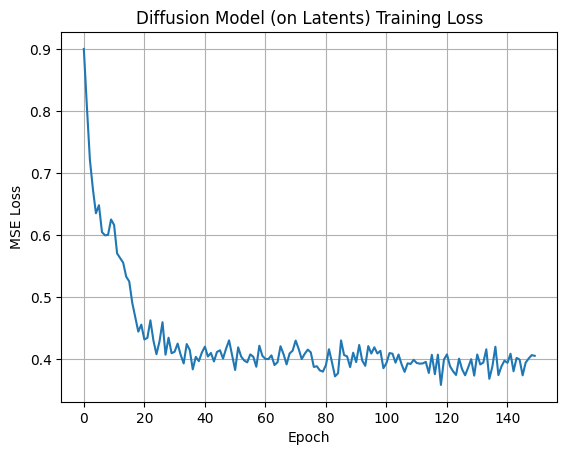

In [ ]:
# Diffusion Hyperparameters (from example, can be tuned)
T_diffusion = 1000  # Number of timesteps

betas = np.linspace(1e-4, 0.02, T_diffusion, dtype=np.float32)

sigmas_diffusion = np.sqrt(betas)
alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas, axis=-1)

sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
# This was not square rooted in the original code
sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - alphas_cumprod)


# Reverse Process Model (MLP for 2D latent space)
def build_reverse_process_model_mlp(latent_dim, time_embedding_dim, num_hidden_layers=3, hidden_layer_width=128):
    """Builds the MLP reverse process model for the latent space."""
    latent_input = layers.Input(shape=(latent_dim,), name='latent_input') # e.g., (2,)
    timestep_input = layers.Input(shape=(1,), name='timestep_input')     # Scalar timestep

    # Timestep embedding
    time_embed = layers.Embedding(input_dim=T_diffusion, output_dim=time_embedding_dim,
                                    embeddings_initializer='glorot_normal')(timestep_input)
    time_embed = layers.Flatten()(time_embed) # Shape from (batch, 1, D) to (batch, D)

    # Concatenate latent vector with time embedding
    merged_input = layers.Concatenate(axis=-1)([latent_input, time_embed])

    # MLP
    x = merged_input
    for _ in range(num_hidden_layers):
        x = layers.Dense(hidden_layer_width, activation='relu')(x)

    # Output predicted noise (same dimension as latent_input)
    output_noise = layers.Dense(latent_dim, activation=None)(x) # Linear activation

    model = Model(inputs=[latent_input, timestep_input], outputs=output_noise)
    return model

# Instantiate the model
latent_dim_for_diffusion = LATENT_DIM_AE # Should be 2
time_embedding_dim_diffusion = 128 # As suggested: "same size as your hidden layers"
hidden_mlp_width = 128

diffusion_model_mlp = build_reverse_process_model_mlp(
    latent_dim_for_diffusion,
    time_embedding_dim_diffusion,
    hidden_layer_width=hidden_mlp_width
)
print("Diffusion Model (MLP for Latents) Summary:")
diffusion_model_mlp.summary()

# Training Setup
diffusion_epochs = 150 # Adjust as needed
diffusion_batch_size = 128
diffusion_learning_rate = 3e-4 # Example uses 3e-4

optimizer_diffusion = keras.optimizers.Adam(learning_rate=diffusion_learning_rate)
loss_fn_diffusion = keras.losses.MeanSquaredError()

# Prepare dataset from latent embeddings
train_dataset_latents = tf.data.Dataset.from_tensor_slices(latent_embeddings_train)
train_dataset_latents = train_dataset_latents.shuffle(buffer_size=len(latent_embeddings_train)).batch(diffusion_batch_size)

print(f"\nTraining Diffusion Model on Latent Embeddings for {diffusion_epochs} epochs...")

# Custom Training Loop (adapted from frey_diffusion_example.py)
diffusion_loss_history = []
for epoch in range(diffusion_epochs):
    total_loss_epoch = 0

    pbar = tqdm(total=len(train_dataset_latents), desc=f"Epoch {epoch+1}/{diffusion_epochs}")
    for step, x0_batch_latents in enumerate(train_dataset_latents):
        # x0_batch_latents are the "clean" 2D latent vectors from AE
        current_batch_size = tf.shape(x0_batch_latents)[0]

        # Sample random timesteps t for this batch
        t_batch = np.random.randint(0, T_diffusion, size=current_batch_size)

        with tf.GradientTape() as tape:
            # Sample random noise $\epsilon \sim N(0,I)$
            noise_batch = tf.random.normal(shape=tf.shape(x0_batch_latents))

            # Get $\sqrt{\bar{\alpha}_t}$ and $\sqrt{1-\bar{\alpha}_t}$ for the sampled timesteps
            # These need to be gathered according to t_batch and reshaped for broadcasting
            sqrt_at_batch = tf.gather(sqrt_alphas_cumprod, t_batch)
            sqrt_one_minus_at_batch = tf.gather(sqrt_one_minus_alphas_cumprod, t_batch)

            # Reshape for broadcasting: (batch_size,) -> (batch_size, 1) for 2D latents
            sqrt_at_batch = tf.reshape(sqrt_at_batch, [current_batch_size, 1])
            sqrt_one_minus_at_batch = tf.reshape(sqrt_one_minus_at_batch, [current_batch_size, 1])

            # Construct noisy latents: $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$
            xt_batch_noisy_latents = sqrt_at_batch * x0_batch_latents + sqrt_one_minus_at_batch * noise_batch

            # Predict noise using the diffusion model
            # Ensure t_batch is correctly shaped for the model: (batch_size, 1)
            t_batch_reshaped_for_model = tf.reshape(t_batch, [current_batch_size, 1])
            predicted_noise_batch = diffusion_model_mlp([xt_batch_noisy_latents, t_batch_reshaped_for_model], training=True)

            # Calculate loss: MSE between actual noise and predicted noise
            loss_value = loss_fn_diffusion(noise_batch, predicted_noise_batch)

        # Compute gradients and update weights
        grads = tape.gradient(loss_value, diffusion_model_mlp.trainable_weights)
        optimizer_diffusion.apply_gradients(zip(grads, diffusion_model_mlp.trainable_weights))

        total_loss_epoch += loss_value.numpy()
        pbar.update(1)
        pbar.set_postfix_str(f"Loss: {loss_value.numpy():.4f}")

    pbar.close()
    avg_loss_epoch = total_loss_epoch / (step + 1)
    diffusion_loss_history.append(avg_loss_epoch)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss_epoch:.4f}")

# Plot diffusion model training loss
plt.figure()
plt.plot(diffusion_loss_history)
plt.title('Diffusion Model (on Latents) Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()


Sampling 1000 latent vectors using the trained diffusion model...


Diffusion Sampling: 100%|██████████| 1000/1000 [00:48<00:00, 20.42it/s]


Shape of sampled latents: (1000, 2)


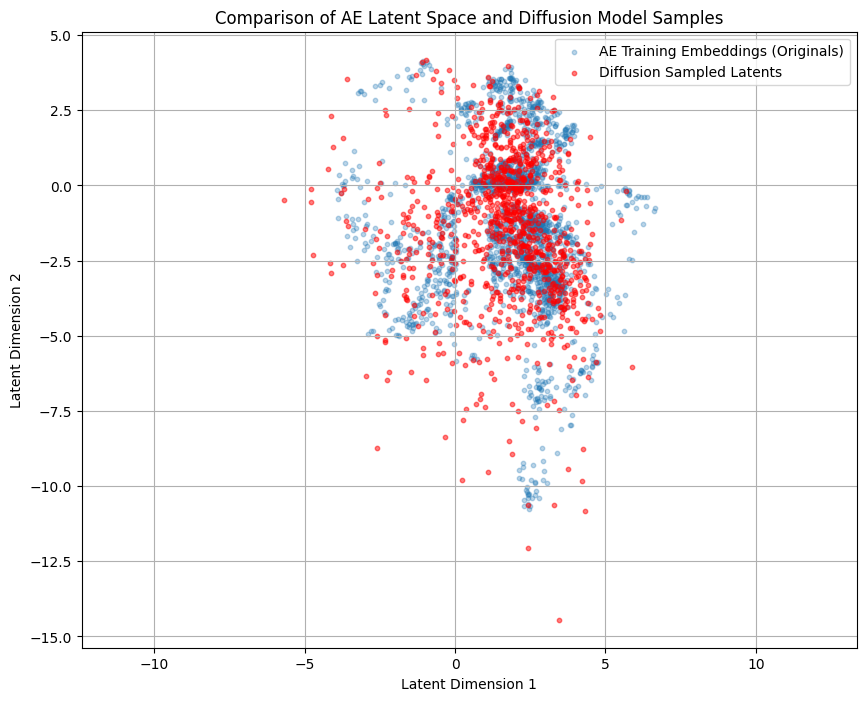


Decoding the first 10 sampled latent vectors into images...


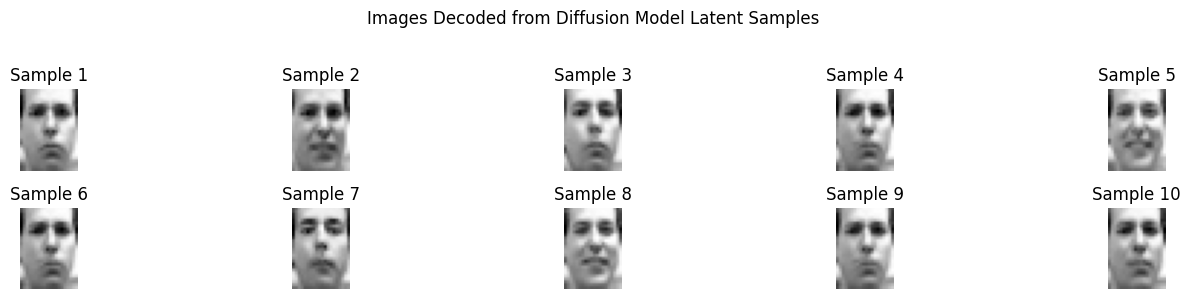

In [22]:
def sample_latents_from_diffusion(model, num_samples, latent_dim, T, alphas_param, alphas_cumprod_param, sigmas_param):
    """Samples latent vectors from the trained diffusion model."""
    # Start with random noise $x_T \sim N(0,I)$
    x_t = tf.random.normal(shape=(num_samples, latent_dim))

    for t_val_rev in trange(T - 1, -1, -1, desc="Diffusion Sampling"): # Iterate t from T-1 down to 0
        t_batch_model = tf.ones((num_samples, 1), dtype=tf.int32) * t_val_rev

        # Sample noise z (unless t=0)
        z = tf.random.normal(shape=(num_samples, latent_dim)) if t_val_rev > 0 else tf.zeros((num_samples, latent_dim))

        # Predict noise $\epsilon_\theta(x_t, t)$
        eps = model.predict([x_t, t_batch_model], verbose=0)

        # Get constants for this timestep t
        alpha_t = alphas_param[t_val_rev]
        alpha_t_bar = alphas_cumprod_param[t_val_rev]
        sigma_t = sigmas_param[t_val_rev] # $\sigma_t = \sqrt{\beta_t}$ or $\sqrt{\tilde{\beta}_t}$ depending on DDPM/DDIM
                                            # Example notebook uses $\sigma_t = \sqrt{\beta_t}$

        # Reshape for broadcasting if necessary (not needed here as all are scalars for 2D)

        # DDPM sampling step formula:
        # $x_{t-1} = \frac{1}{\sqrt{\alpha_t}} (x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta(x_t,t)) + \sigma_t z$
        term1_coeff = 1.0 / np.sqrt(alpha_t)
        term2_coeff = (1.0 - alpha_t) / np.sqrt(1.0 - alpha_t_bar)

        x_t_minus_1 = term1_coeff * (x_t - term2_coeff * eps) + sigma_t * z
        x_t = x_t_minus_1

    return x_t.numpy() # Final $x_0$ samples

# Sample 1000 latent vectors
num_eval_samples_diffusion = 1000
print(f"\nSampling {num_eval_samples_diffusion} latent vectors using the trained diffusion model...")
sampled_latents_diffusion = sample_latents_from_diffusion(
    diffusion_model_mlp,
    num_eval_samples_diffusion,
    latent_dim_for_diffusion,
    T_diffusion,
    alphas, # Global alphas array
    alphas_cumprod, # Global alphas_cumprod array
    sigmas_diffusion # Global sigmas_diffusion array
)
print(f"Shape of sampled latents: {sampled_latents_diffusion.shape}")

# Plot training embeddings and sampled points
plt.figure(figsize=(10, 8))
plt.scatter(latent_embeddings_train[:, 0], latent_embeddings_train[:, 1],
            s=10, alpha=0.3, label='AE Training Embeddings (Originals)')
plt.scatter(sampled_latents_diffusion[:, 0], sampled_latents_diffusion[:, 1],
            s=10, alpha=0.5, color='red', label='Diffusion Sampled Latents')
plt.title('Comparison of AE Latent Space and Diffusion Model Samples')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.grid(True)
plt.axis('equal') # Helps visualize distribution shape
plt.show()

# Decode the first 10 sampled latent vectors into images
num_decode_display = 10
first_10_sampled_latents = sampled_latents_diffusion[:num_decode_display]

print(f"\nDecoding the first {num_decode_display} sampled latent vectors into images...")
decoded_images_from_diffusion = decoder.predict(first_10_sampled_latents, verbose=0)

plt.figure(figsize=(num_decode_display * 1.5, 3)) # Adjusted for 10 images
for i in range(num_decode_display):
    plt.subplot(2, num_decode_display // 2, i + 1) # Assuming 2 rows
    img_display = (decoded_images_from_diffusion[i] + 1.0) / 2.0 # De-normalize
    plt.imshow(np.squeeze(np.clip(img_display, 0, 1)))
    plt.title(f"Sample {i+1}")
    plt.axis('off')
plt.suptitle("Images Decoded from Diffusion Model Latent Samples")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The diffusion model appears to have learned the general distribution of the autoencoder's 2D latent space reasonably well. The scatter plot shows that the 1000 sampled red points largely overlap with the original blue AE training embeddings, capturing the overall shape and density, though with some diffusion samples extending slightly beyond the original training data's boundaries. The 10 decoded images are recognizable as blurry, grayscale faces, similar in style to the Frey dataset, albeit lacking fine detail due to the AE's 2D bottleneck. There's some evidence of mode preference rather than severe mode collapse; while not identical, several decoded faces share strong resemblances, suggesting the diffusion model might favor certain regions of the latent space, or that the 2D latent space itself limits the expressible diversity. But the dataset isn't super diverse to begin with, so doesn't affect outputs too much. It doesn't seem to generate the full nuanced variety of the entire training set, but it avoids collapsing to a single output.